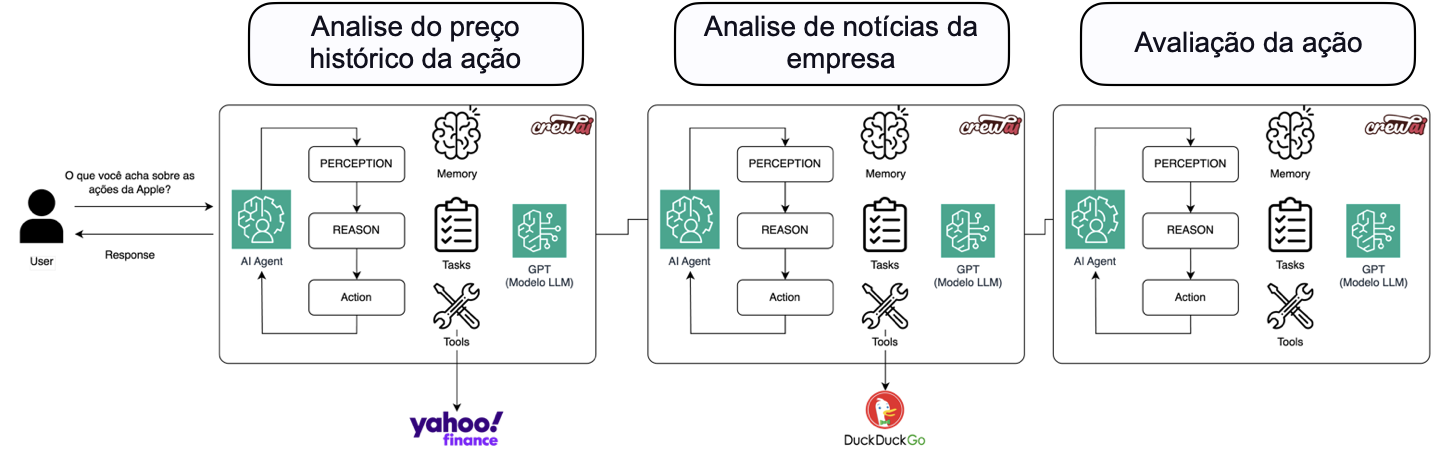

In [1]:
#INSTALAÇÃO DAS LIBS
!pip install yfinance==0.2.41
!pip install crewai==0.28.8
!pip install 'crewai[tools]'
!pip install langchain==0.1.20
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.0.38
!pip install duckduckgo-search==5.3.0

  Using cached yfinance-0.2.41-py2.py3-none-any.whl.metadata (11 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached lxml-5.3.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached frozendict-2.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (23 kB)
  Using cached peewee-3.17.6-cp310-cp310-linux_x86_64.whl
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
  Using cached soupsieve-2.5-py3-none-any.whl.metadata (4.7 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)


In [18]:
#IMPORT DA LIBS
import json 
import os
from datetime import datetime

import yfinance as yf

from crewai import Agent, Task, Crew, Process

from langchain.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchResults

from IPython.display import Markdown

In [19]:
# CRIANDO YAHOO FINANCE TOOL 
def fetch_stock_price(ticket):
    stock = yf.download(ticket, start="2023-08-08", end="2024-08-08")
    return stock

yahoo_finance_tool = Tool(
    name = "Yahoo Finance Tool",
    description = "Fetches stocks prices for {ticket} from the last year about a specific company from Yahoo Finance API",
    func= lambda ticket: fetch_stock_price(ticket)
)

In [20]:
# IMPORTANDO OPENAI LLM - GPT
os.environ['OPENAI_API_KEY']="sua-key"
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [21]:
stockPriceAnalyst = Agent(
    role= "Senior stock price Analyst",
    goal="Find the {ticket} stock price and analyses trends",
    backstory="""You're highly experienced in analyzing the price of an specific stock
    and make predictions about its future price.""",
    verbose=True,
    llm= llm,
    max_iter= 5,
    memory= True,
    tools=[yahoo_finance_tool],
    allow_delegation=False
)

In [22]:
getStockPrice = Task(
    description= "Analyze the stock {ticket} price history and create a trend analyses of up, down or sideways",
    expected_output = """" Specify the current trend stock price - up, down or sideways. 
    eg. stock= 'APPL, price UP'
""",
    agent= stockPriceAnalyst
)

In [23]:
# IMPORTANT A TOOL DE SEARCH 
search_tool = DuckDuckGoSearchResults(backend='news', num_results=10)

In [24]:
newsAnalyst = Agent(
    role= "Stock News Analyst",
    goal="""Create a short summary of the market news related to the stock {ticket} company. Specify the current trend - up, down or sideways with
    the news context. For each request stock asset, specify a numbet between 0 and 100, where 0 is extreme fear and 100 is extreme greed.""",
    backstory="""You're highly experienced in analyzing the market trends and news and have tracked assest for more then 10 years.

    You're also master level analyts in the tradicional markets and have deep understanding of human psychology.

    You understand news, theirs tittles and information, but you look at those with a health dose of skepticism. 
    You consider also the source of the news articles. 
    """,
    verbose=True,
    llm= llm,
    max_iter= 10,
    memory= True,
    tools=[search_tool],
    allow_delegation=False
)

In [25]:
get_news = Task(
    description= f"""Take the stock and always include BTC to it (if not request).
    Use the search tool to search each one individually. 

    The current date is {datetime.now()}.

    Compose the results into a helpfull report""",
    expected_output = """"A summary of the overall market and one sentence summary for each request asset. 
    Include a fear/greed score for each asset based on the news. Use format:
    <STOCK ASSET>
    <SUMMARY BASED ON NEWS>
    <TREND PREDICTION>
    <FEAR/GREED SCORE>
""",
    agent= newsAnalyst
)

In [26]:
stockAnalystWrite = Agent(
    role = "Senior Stock Analyts Writer",
    goal= """"Analyze the trends price and news and write an insighfull compelling and informative 3 paragraph long newsletter based on the stock report and price trend. """,
    backstory= """You're widely accepted as the best stock analyst in the market. You understand complex concepts and create compelling stories
    and narratives that resonate with wider audiences. 

    You understand macro factors and combine multiple theories - eg. cycle theory and fundamental analyses. 
    You're able to hold multiple opinions when analyzing anything.
""",
    verbose = True,
    llm=llm,
    max_iter = 5,
    memory=True,
    allow_delegation = True
)

In [27]:
writeAnalyses = Task(
    description = """Use the stock price trend and the stock news report to create an analyses and write the newsletter about the {ticket} company
    that is brief and highlights the most important points.
    Focus on the stock price trend, news and fear/greed score. What are the near future considerations?
    Include the previous analyses of stock trend and news summary.
""",
    expected_output= """"An eloquent 3 paragraphs newsletter formated as markdown in an easy readable manner. It should contain:

    - 3 bullets executive summary 
    - Introduction - set the overall picture and spike up the interest
    - main part provides the meat of the analysis including the news summary and fead/greed scores
    - summary - key facts and concrete future trend prediction - up, down or sideways.
""",
    agent = stockAnalystWrite,
    context = [getStockPrice, get_news]
)

In [28]:
crew = Crew(
    agents = [stockPriceAnalyst, newsAnalyst, stockAnalystWrite],
    tasks = [getStockPrice, get_news, writeAnalyses],
    verbose = 2,
    process= Process.hierarchical,
    full_output=True,
    share_crew=False,
    manager_llm=llm,
    max_iter=15
)

2024-08-12 22:40:04,166 - 128468971327488 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


In [29]:
results= crew.kickoff(inputs={'ticket': 'AAPL'})

 [DEBUG]: Working Agent: Crew Manager
 [INFO]: Starting Task: Analyze the stock AAPL price history and create a trend analyses of up, down or sideways


> Entering new CrewAgentExecutor chain...
I need to gather information on the stock AAPL price history and create a trend analysis to determine if the current trend is up, down, or sideways. I should delegate the task of analyzing the stock price history to the Senior Stock Price Analyst and ask for their input on the current trend.

Action: Delegate work to co-worker
Action Input: {"coworker": "Senior Stock Price Analyst", "task": "Analyze AAPL stock price history and determine current trend", "context": "I need you to analyze the historical stock price data for AAPL and provide me with insights on whether the current trend is up, down, or sideways."}

> Entering new CrewAgentExecutor chain...


[*********************100%%**********************]  1 of 1 completed

I need to use the Yahoo Finance Tool to fetch the historical stock price data for AAPL and analyze the trends to determine the current trend.

Action: Yahoo Finance Tool
Action Input: {"ticket": "AAPL"} 

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-08  179.690002  180.270004  177.580002  179.800003  178.850159   
2023-08-09  180.869995  180.929993  177.009995  178.190002  177.248688   
2023-08-10  179.479996  180.750000  177.600006  177.970001  177.029831   
2023-08-11  177.320007  178.619995  176.550003  177.789993  177.089600   
2023-08-14  177.970001  179.690002  177.309998  179.460007  178.753036   
...                ...         ...         ...         ...         ...   
2024-08-01  224.369995  224.479996  217.020004  218.360001  218.360001   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.860001   
2024-08-05  199.089996  213.500000  196.000000  209.270

Final Answer: Based on the historical stock price data for AAPL from the past year, the current trend appears to be fluctuating with no clear direction. The stock prices have shown periods of increase, decrease, and sideways movement, indicating a lack of a consistent trend. It is recommended to continue monitoring the stock's performance closely for further insights.

> Finished chain.
 

Based on the historical stock price data for AAPL from the past year, the current trend appears to be fluctuating with no clear direction. The stock prices have shown periods of increase, decrease, and sideways movement, indicating a lack of a consistent trend. It is recommended to continue monitoring the stock's performance closely for further insights.

Thought: 
I have gathered the necessary information from the Senior Stock Price Analyst regarding the AAPL stock price history and the current trend. Now, I need to formulate the final answer based on the analysis provided.

Final Answer: 
stock= 'A

In [30]:
list(results.keys())

['final_output', 'tasks_outputs']

In [31]:
results['final_output']

"Dear readers,\n\nIn analyzing the current trends and news surrounding AAPL's stock, it is evident that there is a mixed sentiment in the market. On one hand, there are positive indicators such as upcoming product launches and strong earnings reports that suggest growth potential for the company. However, there are also concerns over supply chain disruptions and regulatory challenges that have contributed to a fear-driven sentiment among investors. It is crucial for investors to closely monitor these developments and consider diversifying their portfolios to mitigate risks associated with market volatility and uncertainties surrounding AAPL's future performance.\n\nTaking into account the macro factors at play and combining cycle theory with fundamental analysis, it is clear that AAPL's stock price is influenced by a complex interplay of various factors. As the Senior Stock Analyst, it is important to hold multiple opinions and consider all angles when analyzing AAPL's stock trend and 

In [32]:
len(results['tasks_outputs'])

3

In [33]:
Markdown(results['final_output'])

Dear readers,

In analyzing the current trends and news surrounding AAPL's stock, it is evident that there is a mixed sentiment in the market. On one hand, there are positive indicators such as upcoming product launches and strong earnings reports that suggest growth potential for the company. However, there are also concerns over supply chain disruptions and regulatory challenges that have contributed to a fear-driven sentiment among investors. It is crucial for investors to closely monitor these developments and consider diversifying their portfolios to mitigate risks associated with market volatility and uncertainties surrounding AAPL's future performance.

Taking into account the macro factors at play and combining cycle theory with fundamental analysis, it is clear that AAPL's stock price is influenced by a complex interplay of various factors. As the Senior Stock Analyst, it is important to hold multiple opinions and consider all angles when analyzing AAPL's stock trend and news. By understanding the broader market dynamics and staying informed on the latest updates, investors can make well-informed decisions that align with their investment goals and risk tolerance. In conclusion, staying vigilant and adaptable in response to changing market conditions will be key in navigating the current landscape surrounding AAPL's stock.